# Implementing uncertainty associated with f-factor estimations to summarize data using the Kent distribution

## Import scientific Python packages

In [170]:
import numpy as np
import pandas as pd

import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib

import cartopy.crs as ccrs
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D

%config InlineBackend.figure_format = 'retina'

## functions for plotting spherical direction distributions and contours

In [119]:
def bin_trace(lon_samples, lat_samples, resolution):
    """
    Given a trace of samples in longitude and latitude, bin them
    in latitude and longitude, and normalize the bins so that
    the integral of probability density over the sphere is one.

    The resolution keyword gives the number of divisions in latitude.
    The divisions in longitude is twice that.
    """
    lats = np.linspace(-90., 90., resolution, endpoint=True)
    lons = np.linspace(-180., 180., 2 * resolution, endpoint=True)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    hist = np.zeros_like(lon_grid)

    dlon = 360. / (2. * resolution)
    dlat = 180. / resolution

    for lon, lat in zip(lon_samples, lat_samples):

        lon = np.mod(lon, 360.)
        if lon > 180.:
            lon = lon - 360.
        if lat < -90. or lat > 90.:
            # Just skip invalid latitudes if they happen to arise
            continue

        lon_index = int(np.floor((lon + 180.) / dlon))
        lat_index = int(np.floor((lat + 90.) / dlat))
        hist[lat_index, lon_index] += 1

    lat_grid += dlat / 2.
    lon_grid += dlon / 2.
    return lon_grid, lat_grid, hist


def density_distribution(lon_samples, lat_samples, resolution=30):
    count = len(lon_samples)
    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)
    return lon_grid, lat_grid, hist / count


def cumulative_density_distribution(lon_samples, lat_samples, resolution=30):

    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)

    # Compute the cumulative density
    hist = hist.ravel()
    i_sort = np.argsort(hist)[::-1]
    i_unsort = np.argsort(i_sort)
    hist_cumsum = hist[i_sort].cumsum()
    hist_cumsum /= hist_cumsum[-1]

    return lon_grid, lat_grid, hist_cumsum[i_unsort].reshape(lat_grid.shape)


def plot_distributions(ax, lon_samples, lat_samples, to_plot='d', resolution=100, **kwargs):

    cmap=kwargs.get('cmap', 'viridis')

    artists = []

    if 'd' in to_plot:
        lon_grid, lat_grid, density = density_distribution(
            lon_samples, lat_samples, resolution)
        density = ma.masked_where(density <= 0.05*density.max(), density)
        a = ax.pcolormesh(lon_grid, lat_grid, density, cmap=cmap,
                          transform=ccrs.PlateCarree())
        artists.append(a)

    if 'e' in to_plot:
        lon_grid, lat_grid, cumulative_density = cumulative_density_distribution(
            lon_samples, lat_samples, resolution)
        a = ax.contour(lon_grid, lat_grid, cumulative_density, levels=[
                       0.95], colors=kwargs.get('colors', 'k'), transform=ccrs.PlateCarree(), 
                       linewidths=kwargs.get('lw', 1), zorder = kwargs.get('zorder', 100))
        artists.append(a)

    if 's' in to_plot:
        a = ax.scatter(lon_samples, lat_samples, color=kwargs.get('color', 'C0'), alpha=0.1, transform=ccrs.PlateCarree(), edgecolors=None, **kwargs)
        artists.append(a)

    return artists

## modified function for plotting E/I cumulative distribution function

In [24]:
def plot_cdf(fignum, data, xlab, sym, title, **kwargs):
    """ Makes a plot of the cumulative distribution function.
    Parameters
    __________
    fignum : matplotlib figure number
    data : list of data to be plotted - doesn't need to be sorted
    sym : matplotlib symbol for plotting, e.g., 'r--' for a red dashed line
    **kwargs :  optional dictionary with {'color': color, 'linewidth':linewidth}

    Returns
    __________
    x : sorted list of data
    y : fraction of cdf
    """
#
    #if len(sym)==1:sym=sym+'-'
    fig = plt.figure(num=fignum)
    # sdata=np.array(data).sort()
    sdata = []
    for d in data:
        sdata.append(d)  # have to copy the data to avoid overwriting it!
    sdata.sort()
    X, Y = [], []
    color = ""
    for j in range(len(sdata)):
        Y.append(float(j)/float(len(sdata)))
        X.append(sdata[j])
    if 'color' in list(kwargs.keys()):
        color = kwargs['color']
    if 'linewidth' in list(kwargs.keys()):
        lw = kwargs['linewidth']
    else:
        lw = 1
    if color != "":
        plt.plot(X, Y, color=color, linewidth=lw)
    else:
        plt.plot(X, Y, sym, linewidth=lw)

    plt.xlabel(xlab, fontsize=12)
    plt.ylabel('Cumulative Distribution', fontsize=12)
    plt.title(title)
    return X, Y

## modify E/I so that one can control the color of the E/I plots

In [67]:
def find_ei(data, nb=1000, save=False, save_folder='.', fmt='svg',
            site_correction=False, return_new_dirs=False, figprefix='EI', return_values=False):
    print("Bootstrapping.... be patient")
    print("")
#     sys.stdout.flush()

    upper, lower = int(round(.975 * nb)), int(round(.025 * nb))
    E, I = [], []

    plt.figure(num=1, figsize=(4, 4))
    ipmag.plot_net(1)
    ipmag.plot_di(di_block=data)
    plt.title('Original')

    ppars = pmag.doprinc(data)
    Io = ppars['inc']
    n = ppars["N"]
    Es, Is, Fs, V2s = pmag.find_f(data)
    if site_correction == True:
        Inc, Elong = Is[Es.index(min(Es))], Es[Es.index(min(Es))]
        flat_f = Fs[Es.index(min(Es))]
    else:
        Inc, Elong = Is[-1], Es[-1]
        flat_f = Fs[-1]

    plt.figure(num=2, figsize=(4, 4))
    plt.plot(Is, Es, 'r', zorder = nb+1, lw=3)
    plt.xlabel("Inclination", fontsize=12)
    plt.ylabel("Elongation", fontsize=12)
    plt.text(Inc, Elong, ' %4.2f' % (flat_f), fontsize=12)
#     plt.text(Is[0] - 2, Es[0], ' %s' % ('f=1'), fontsize=12)

    b = 0

    while b < nb:
        bdata = pmag.pseudo(data)
        Esb, Isb, Fsb, V2sb = pmag.find_f(bdata)
        if b < nb:
            plt.plot(Isb, Esb, 'grey', alpha=0.05)
        if Esb[-1] != 0:
            ppars = pmag.doprinc(bdata)
            if site_correction == True:
                I.append(abs(Isb[Esb.index(min(Esb))]))
                E.append(Esb[Esb.index(min(Esb))])
            else:
                I.append(abs(Isb[-1]))
                E.append(Esb[-1])
            b += 1

    I.sort()
    E.sort()
    Eexp = []
    for i in I:
        Eexp.append(pmag.EI(i))
    plt.plot(I, Eexp, 'k', alpha=1)
    if Inc == 0:
        title = 'Pathological Distribution: ' + \
            '[%7.1f, %7.1f]' % (I[lower], I[upper])
    else:
        title = '%7.1f [%7.1f, %7.1f]' % (Inc, I[lower], I[upper])
    if save:
        plt.savefig(save_folder+'/'+figprefix+'_EI_bootstraps'+'.'+fmt, bbox_inches='tight', dpi=300)

    cdf_fig_num = 3
    plt.figure(num=cdf_fig_num, figsize=(4, 4))
    plot_cdf(cdf_fig_num, I, 'Inclinations', 'r', title)
    pmagplotlib.plot_vs(cdf_fig_num, [I[lower], I[upper]], 'b', '--')
    pmagplotlib.plot_vs(cdf_fig_num, [Inc], 'g', '-')
    pmagplotlib.plot_vs(cdf_fig_num, [Io], 'k', '-')
    if save:
        plt.savefig(save_folder+'/'+figprefix+'_inc_CDF'+'.'+fmt, bbox_inches='tight', dpi=300)

    # plot corrected directional data

    di_lists = ipmag.unpack_di_block(data)
    if len(di_lists) == 3:
        decs, incs, intensity = di_lists
    if len(di_lists) == 2:
        decs, incs = di_lists
    if flat_f:
        unsquished_incs = ipmag.unsquish(incs, flat_f)
        plt.figure(num=4, figsize=(4, 4))
        ipmag.plot_net(4)
        ipmag.plot_di(decs, unsquished_incs)
        plt.title('Corrected for flattening')
    else:
        plt.figure(num=4, figsize=(4, 4))
        ipmag.plot_net(4)
        ipmag.plot_di(decs, incs)
        plt.title('Corrected for flattening')
    if save:
        plt.savefig(save_folder+'/'+figprefix+'_corrected_directions'+'.'+fmt, bbox_inches='tight', dpi=300)

    if (Inc, Elong, flat_f) == (0, 0, 0):
        print("PATHOLOGICAL DISTRIBUTION")
    print("The original inclination was: " + str(np.round(Io,2)))
    print("")
    print("The corrected inclination is: " + str(np.round(Inc,2)))
    print("with bootstrapped confidence bounds of: " +
          str(np.round(I[lower],2)) + ' to ' + str(np.round(I[upper],2)))
    print("and elongation parameter of: " + str(np.round(Elong,2)))
    print("The flattening factor is: " + str(np.round(flat_f,2)))
    f_lower = np.tan(np.deg2rad(Io))/np.tan(np.deg2rad(I[lower]))
    f_upper = np.tan(np.deg2rad(Io))/np.tan(np.deg2rad(I[upper]))
    print("with bootstrapped confidence bounds of: " +
           str(np.round(f_lower,2)) + ' to ' + str(np.round(f_upper,2)))
    
    F = np.tan(np.deg2rad(Io))/np.tan(np.deg2rad(I))
    
    if return_new_dirs and return_values :
        return make_di_block(decs, unsquished_incs), I, E, F
    
    elif return_new_dirs:
        return make_di_block(decs, unsquished_incs)
    elif return_values:
        return I, E, F
    else:
        return

## modify plot functions to for poles and VGP such that transparency can be applied

In [73]:
def plot_pole(map_axis, plon, plat, A95, label='', color='k', edgecolor='k',
              marker='o', markersize=20, legend='no',outline=True,
              filled_pole=False, fill_color='k', fill_alpha=1.0, mean_alpha = 1.0, A95_alpha=1.0):
    """
    This function plots a paleomagnetic pole and A95 error ellipse on a cartopy map axis.

    Before this function is called, a plot needs to be initialized with code
    such as that in the make_orthographic_map function.

    Example
    -------
    >>> plon = 200
    >>> plat = 60
    >>> A95 = 6
    >>> map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=30)
    >>> ipmag.plot_pole(map_axis, plon, plat, A95 ,color='red',markersize=40)

    Required Parameters
    -----------
    map_axis : the name of the current map axis that has been developed using cartopy
    plon : the longitude of the paleomagnetic pole being plotted (in degrees E)
    plat : the latitude of the paleomagnetic pole being plotted (in degrees)
    A95 : the A_95 confidence ellipse of the paleomagnetic pole (in degrees)

    Optional Parameters (defaults are used if not specified)
    -----------
    color : symbol color; the default color is black. Other colors can be chosen (e.g. 'r')
    marker : the default marker is a circle. Other symbols can be chosen (e.g. 's')
    markersize : the default is 20. Other size can be chosen
    label : the default is no label. Labels can be assigned.
    legend : the default is no legend ('no'). Putting 'yes' will plot a legend.
    filled_pole : if True, the A95 ellipse will be filled with color
    fill_color : color of fill; the default is black.
    fill_alpha : transparency of filled ellipse (the default is 1.0; no transparency).
    """
#     if not has_cartopy:
#         print('-W- cartopy must be installed to run ipmag.plot_pole')
#         return
    A95_km = A95 * 111.32
    map_axis.scatter(plon, plat, marker=marker,
                     color=color, edgecolors=edgecolor, s=markersize,
                     label=label, zorder=101, transform=ccrs.PlateCarree(), alpha = mean_alpha)
    if filled_pole==False:
        ipmag.equi(map_axis, plon, plat, A95_km, color, alpha=A95_alpha)
    elif filled_pole==True:
        ipmag.equi(map_axis, plon, plat, A95_km, fill_color, alpha=fill_alpha, outline=outline,fill=True)
    if legend == 'yes':
        plt.legend(loc=2)

In [131]:
def plot_vgp(map_axis, vgp_lon=None, vgp_lat=None, di_block=None, label='', color='k', marker='o',
             edge='black', markersize=20, alpha=1, legend=False):
    """
    This function plots a paleomagnetic pole position on a cartopy map axis.

    Before this function is called, a plot needs to be initialized with code
    such as that in the make_orthographic_map function.

    Example
    -------
    >>> vgps = ipmag.fishrot(dec=200,inc=30)
    >>> vgp_lon_list,vgp_lat_list,intensities= ipmag.unpack_di_block(vgps)
    >>> map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=30)
    >>> ipmag.plot_vgp(map_axis,vgp_lon=vgp_lon_list,vgp_lat=vgp_lat_list,color='red',markersize=40)

    Required Parameters
    -----------
    map_axis : the name of the current map axis that has been developed using cartopy
    plon : the longitude of the paleomagnetic pole being plotted (in degrees E)
    plat : the latitude of the paleomagnetic pole being plotted (in degrees)

    Optional Parameters (defaults are used if not specified)
    -----------
    color : the color desired for the symbol (default is 'k' aka black)
    marker : the marker shape desired for the pole mean symbol (default is 'o' aka a circle)
    edge : the color of the edge of the marker (default is black)
    markersize : size of the marker in pt (default is 20)
    alpha : the transparency of the points (defaul is 1 which is opaque, 0 is fully transparent)
    label : the default is no label. Labels can be assigned.
    legend : the default is no legend (False). Putting True will plot a legend.
    """
#     if not has_cartopy:
#         print('-W- cartopy must be installed to run ipmag.plot_vgp')
#         return
    if di_block != None:
        di_lists = unpack_di_block(di_block)
        if len(di_lists) == 3:
            vgp_lon, vgp_lat, intensity = di_lists
        if len(di_lists) == 2:
            vgp_lon, vgp_lat = di_lists
    map_axis.scatter(vgp_lon, vgp_lat, marker=marker, edgecolors=edge,
                     s=markersize, color=color, label=label, zorder=1, transform=ccrs.PlateCarree(), alpha=alpha)
    map_axis.set_global()
    if legend == True:
        plt.legend(loc=2)

## Import data and filter by component

In [3]:
Cutface_specimens = pd.read_csv('../../data/Pmag/cutface/specimens.txt', sep='\t', header=1)

Cutface_lat = 47.73055
Cutface_lon = -90.44128

Cutface_specimens['slat'] = Cutface_lat
Cutface_specimens['slon'] = Cutface_lon

In [4]:
specimens_mt_geo = Cutface_specimens[(Cutface_specimens['dir_comp']=='mt') & (Cutface_specimens['dir_tilt_correction']==0)]
specimens_mt_tc = Cutface_specimens[(Cutface_specimens['dir_comp']=='mt') & (Cutface_specimens['dir_tilt_correction']==100)]

specimens_ht_geo = Cutface_specimens[(Cutface_specimens['dir_comp']=='ht') & (Cutface_specimens['dir_tilt_correction']==0)]
specimens_ht_tc = Cutface_specimens[(Cutface_specimens['dir_comp']=='ht') & (Cutface_specimens['dir_tilt_correction']==100)]
specimens_ht_tc['plon'] = pmag.dia_vgp(specimens_ht_tc[['dir_dec', 'dir_inc', 'dir_alpha95', 'slat', 'slon']].to_numpy())[0]
specimens_ht_tc['plat'] = pmag.dia_vgp(specimens_ht_tc[['dir_dec', 'dir_inc', 'dir_alpha95', 'slat', 'slon']].to_numpy())[1]

In [5]:
# filter out the only negative inclination data
#specimens_ht_tc=specimens_ht_tc[specimens_ht_tc['dir_inc']>0]

In [6]:
mean_mt = ipmag.fisher_mean(specimens_mt_tc['dir_dec'].tolist(),specimens_mt_tc['dir_inc'].tolist())
mean_ht = ipmag.fisher_mean(specimens_ht_tc['dir_dec'].tolist(),specimens_ht_tc['dir_inc'].tolist())

In [7]:
mean_mt

{'dec': 287.17888483239904,
 'inc': 41.57971127654676,
 'n': 160,
 'r': 157.10927995957664,
 'k': 55.003596950437874,
 'alpha95': 1.5158428764393486,
 'csd': 10.921680643707267}

In [8]:
mean_ht

{'dec': 287.2295636872718,
 'inc': 29.007417112946914,
 'n': 152,
 'r': 148.44262899177824,
 'k': 42.447076689783025,
 'alpha95': 1.7756643774953274,
 'csd': 12.432576090443026}

## mt component directions

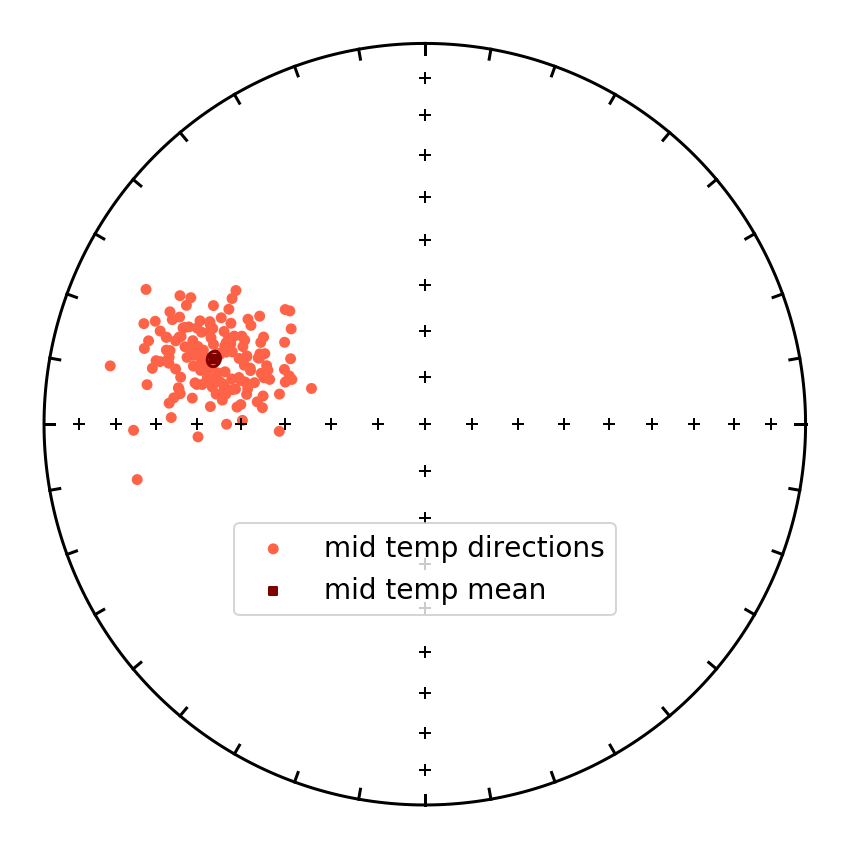

In [7]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(specimens_mt_tc['dir_dec'].tolist(),specimens_mt_tc['dir_inc'].tolist(),color='tomato',label='mid temp directions')

ipmag.plot_di_mean(mean_mt['dec'],mean_mt['inc'],mean_mt['alpha95'],
                    color='maroon', marker = 's', label='mid temp mean')

plt.legend(loc=8,bbox_to_anchor=(0.50,0.25),fontsize=14)
plt.show()

## ht component directions

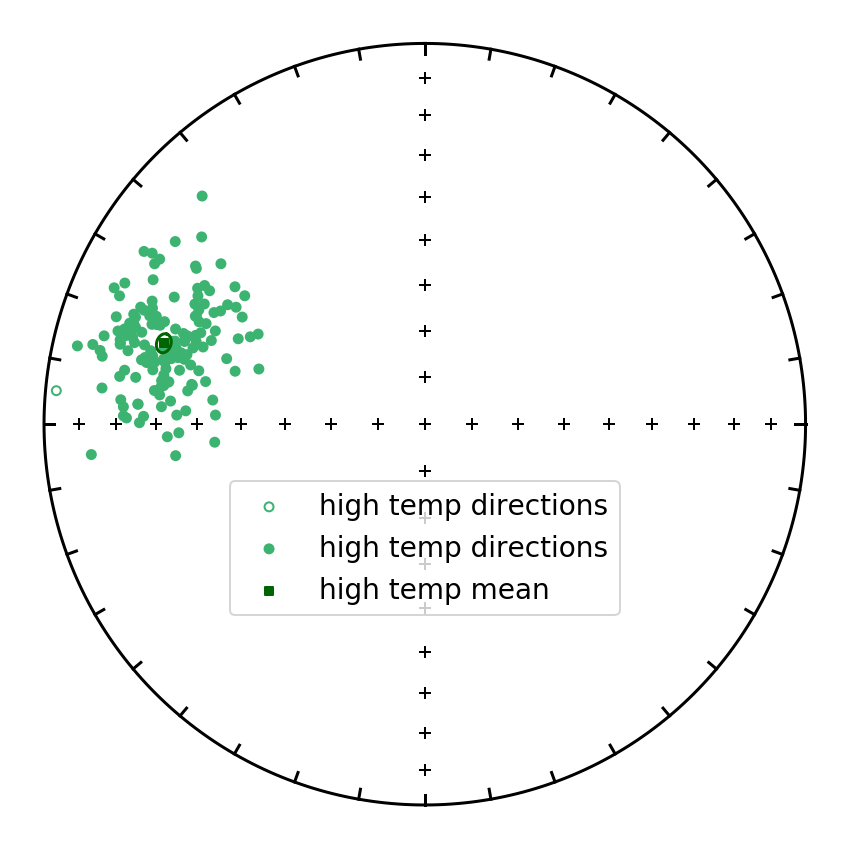

In [8]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(specimens_ht_tc['dir_dec'].tolist(),specimens_ht_tc['dir_inc'].tolist(),color='mediumseagreen',label='high temp directions')

ipmag.plot_di_mean(mean_ht['dec'],mean_ht['inc'],mean_ht['alpha95'],
                   color='darkgreen', marker = 's', label='high temp mean')

plt.legend(loc=8,bbox_to_anchor=(0.50,0.25),fontsize=14)
plt.show()

## mid temp (CRM) and high temp (DRM) directions compared to NSVG direction mean

In [9]:
NSVG_pole_lat = 31.1 
NSVG_pole_lon = 181.7
NSVG_A95 = 4.2

NSVG_dec, NSVG_inc = pmag.vgp_di(NSVG_pole_lat,NSVG_pole_lon,Cutface_lat, Cutface_lon)

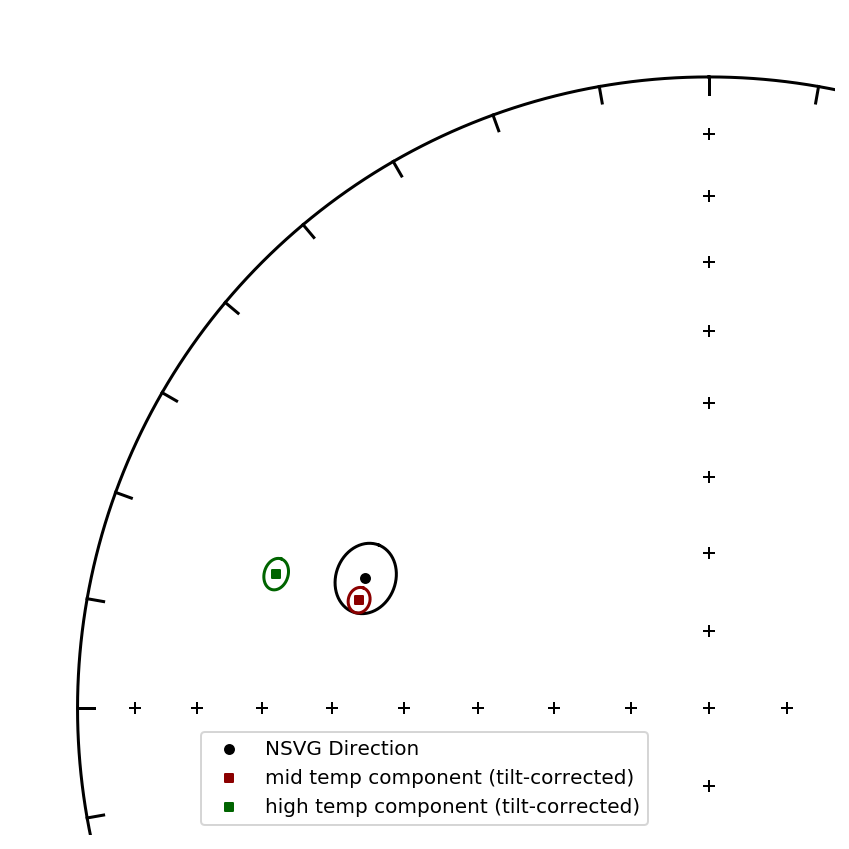

In [10]:
cf_igrf_nsvg_stereonet=plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di_mean(NSVG_dec, NSVG_inc, NSVG_A95, label='NSVG Direction') #need to replace with direction A95

ipmag.plot_di_mean(mean_mt['dec'],mean_mt['inc'],mean_mt['alpha95'],
                   color='darkred', marker = 's', label='mid temp component (tilt-corrected)')
ipmag.plot_di_mean(mean_ht['dec'],mean_ht['inc'],mean_ht['alpha95'],
                   color='darkgreen', marker = 's', label='high temp component (tilt-corrected)')

plt.xlim(-.7, -0.2)
plt.ylim(-0.2,1.1)
plt.legend(loc=8)
plt.show()

Bootstrapping.... be patient

The original inclination was: 29.04

The corrected inclination is: 38.52
with bootstrapped confidence bounds of: 32.71 to 44.5
and elongation parameter of: 2.0
The flattening factor is: 0.68
with bootstrapped confidence bounds of: 0.86 to 0.56


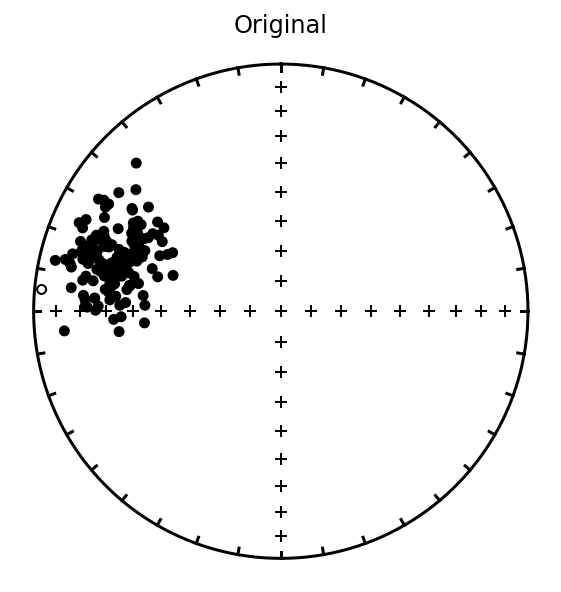

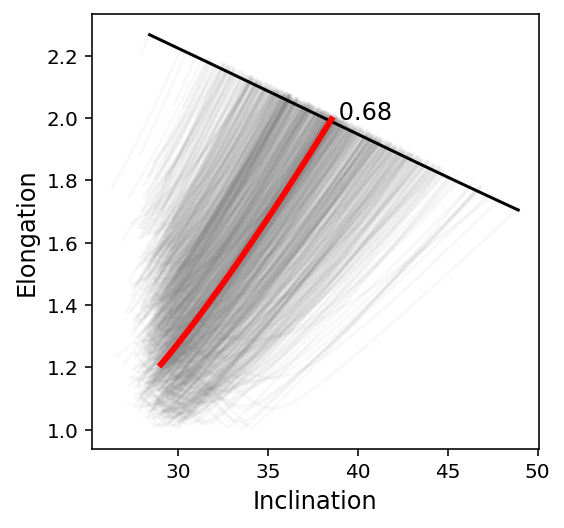

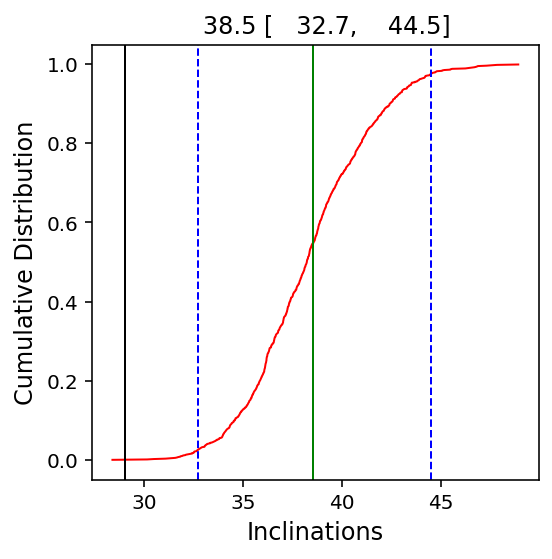

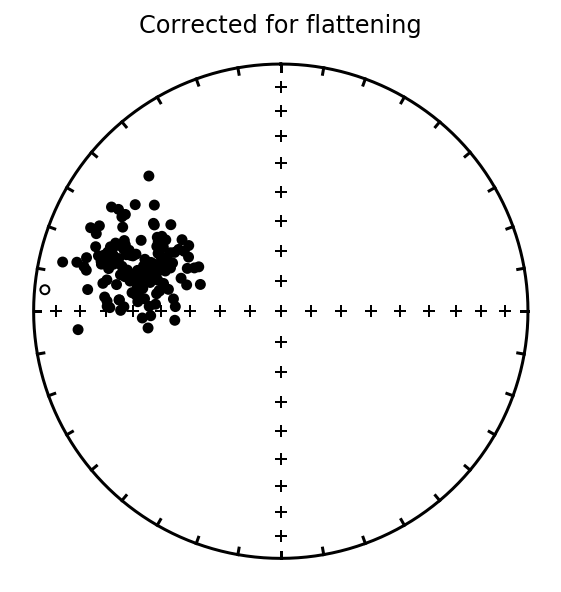

In [68]:
EI_incs, EI_elongs, EI_fs = find_ei(specimens_ht_tc[['dir_dec', 'dir_inc']].to_numpy(), nb=1000, 
                                    return_values = 1, save=1, save_folder='../code_output', fmt='png')

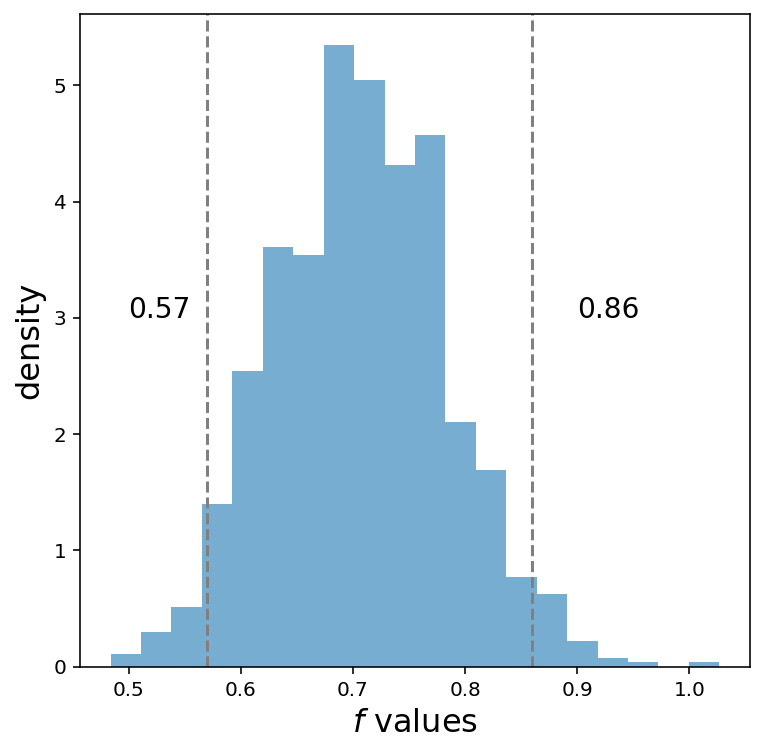

In [69]:
lower, upper = np.round(np.percentile(EI_fs, [2.5, 97.5]), 2)

plt.figure(figsize=(6,6))
plt.hist(EI_fs, bins=20, alpha=0.6, density=1)
# plt.title('All $f$ factors from bootstrap $E/I$ result', fontsize=14)

plt.axvline(x=lower, color = 'gray', ls='--')
plt.axvline(x=upper, color = 'gray', ls='--')

plt.text(0.5, 3, str(lower), fontsize=14)
plt.text(0.9, 3, str(upper), fontsize=14)

plt.xlabel('$f$ values', fontsize=16)
plt.ylabel('density', fontsize=16)

plt.savefig('../code_output/EI_f_histogram.pdf', bbox_inches='tight')
plt.show()

In [49]:
upper

0.53695391659621

### show all unsquished directions according to E/I bootstrap results

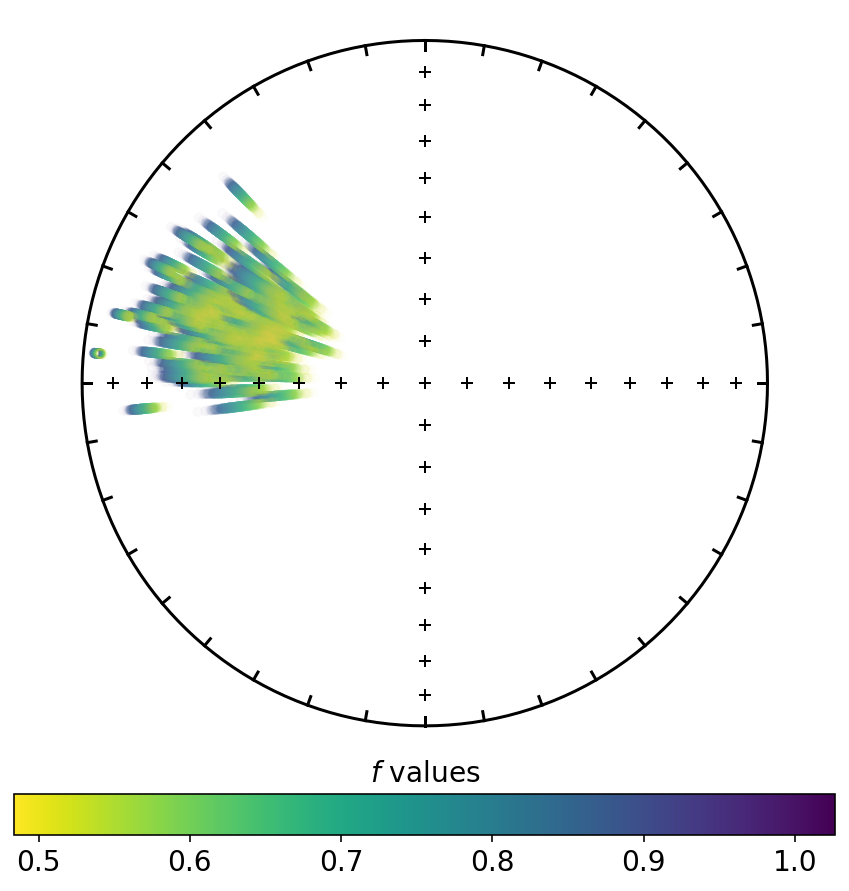

In [147]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()

plt.figure(figsize=(6,6))
ipmag.plot_net()
cNorm  = matplotlib.colors.Normalize(vmin=min(EI_fs), vmax=max(EI_fs))
f_scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

for f in EI_fs:
    rgba = f_scalarMap.to_rgba(f)
    hex_color = colors.rgb2hex(rgba)
    
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    ipmag.plot_di(specimens_ht_tc_decs, unsquish_incs, color = hex_color, alpha=0.02)
cb = plt.colorbar(f_scalarMap,orientation='horizontal',fraction=0.05, pad=0.05)
cb.ax.tick_params(labelsize=14)
cb.ax.set_title(label='$f$ values', fontsize=14)
plt.savefig('../code_output/bootstrap_directions.png', dpi=300, bbox_inches='tight')

<Figure size 576x576 with 0 Axes>

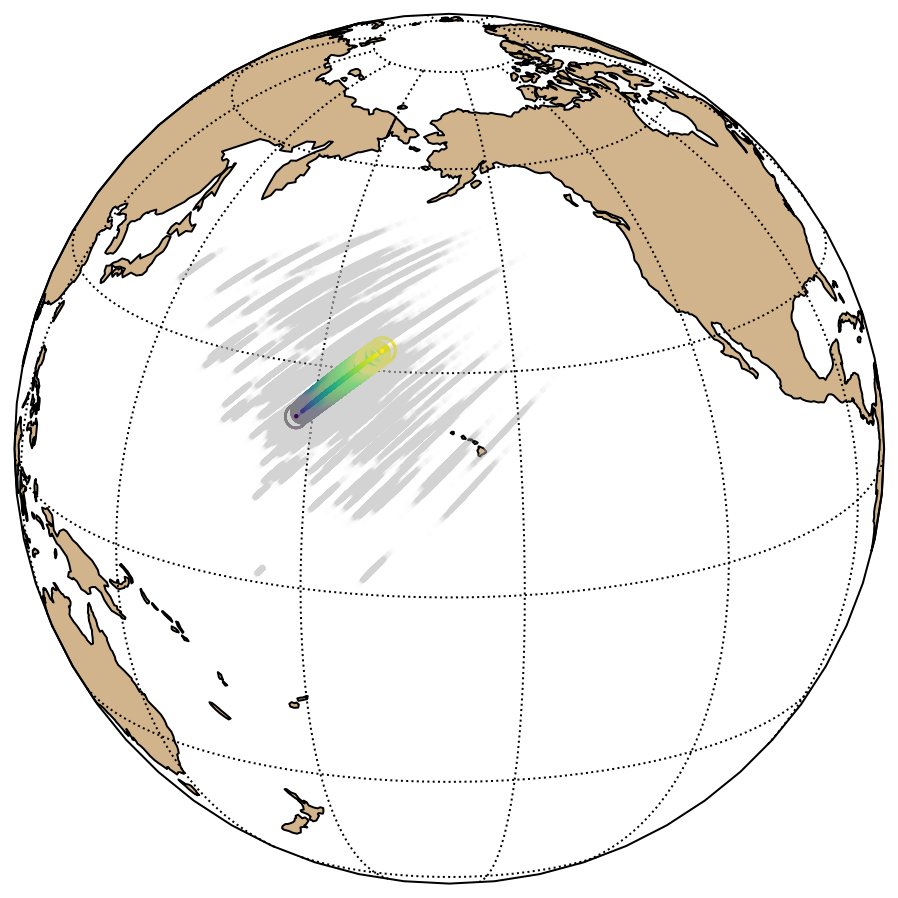

In [79]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
for f in EI_fs:
    rgba = f_scalarMap.to_rgba(f)
    hex_color = colors.rgb2hex(rgba)
    
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    plot_vgp(m, unsquish_lons, unsquish_lats, color = 'lightgray', edge=None, markersize=5, alpha=0.01)

    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    unsquish_VGPs_mean = ipmag.fisher_mean(unsquish_lons, unsquish_lats)
    plot_pole(m, unsquish_VGPs_mean['dec'], unsquish_VGPs_mean['inc'], unsquish_VGPs_mean['alpha95'], 
                    color=hex_color, edgecolor='none', markersize=5, mean_alpha=1, A95_alpha=1)
plt.savefig('../code_output/bootstrap_poles.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 576x576 with 0 Axes>

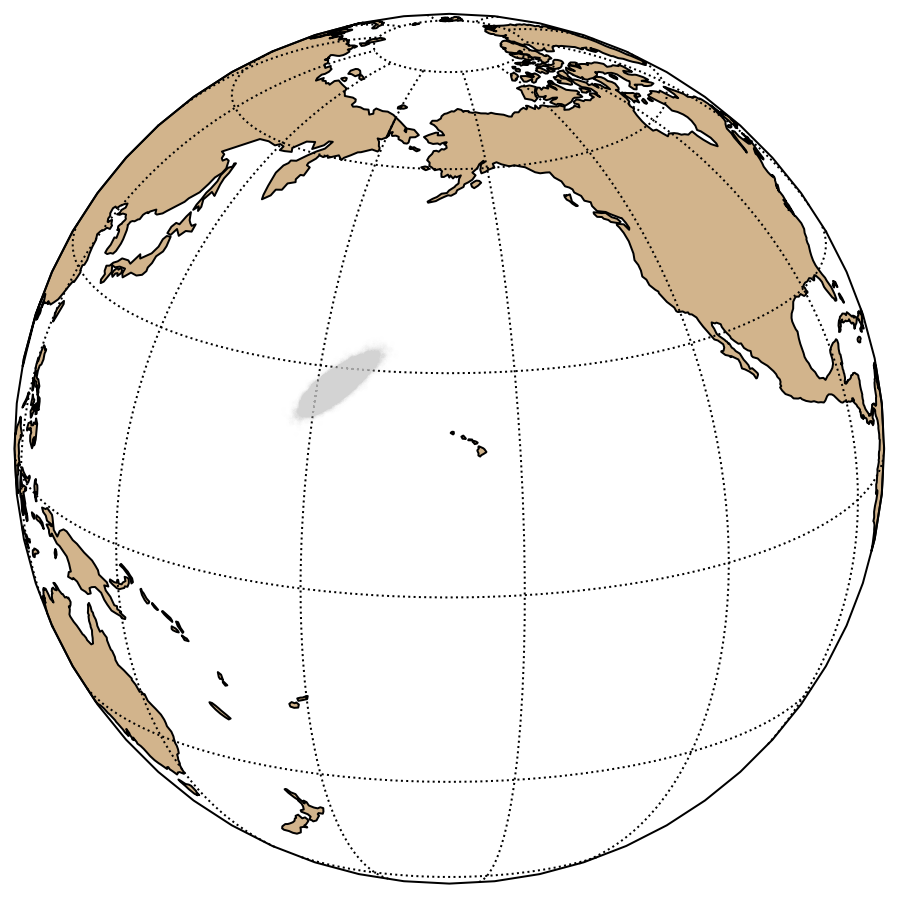

In [80]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

mean_lons = []
mean_lats = []

for f in EI_fs:
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    unsquish_VGPs_mean = ipmag.fisher_mean(unsquish_lons, unsquish_lats)
    resampled_lons, resampled_lats = ipmag.fisher_mean_resample(alpha95=unsquish_VGPs_mean['alpha95'], n=100, 
                                                   dec=unsquish_VGPs_mean['dec'], inc=unsquish_VGPs_mean['inc'], di_block=0)
    mean_lons.extend(resampled_lons)
    mean_lats.extend(resampled_lats)

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
plot_vgp(m, mean_lons, mean_lats, color='lightgrey', edge='none', markersize=5, alpha=0.02)

plt.savefig('../code_output/bootstrap_pole_resample.png', dpi=300, bbox_inches='tight')

In [82]:
kent_distribution_95 = ipmag.kent_distribution_95(dec=mean_lons,inc=mean_lats) 

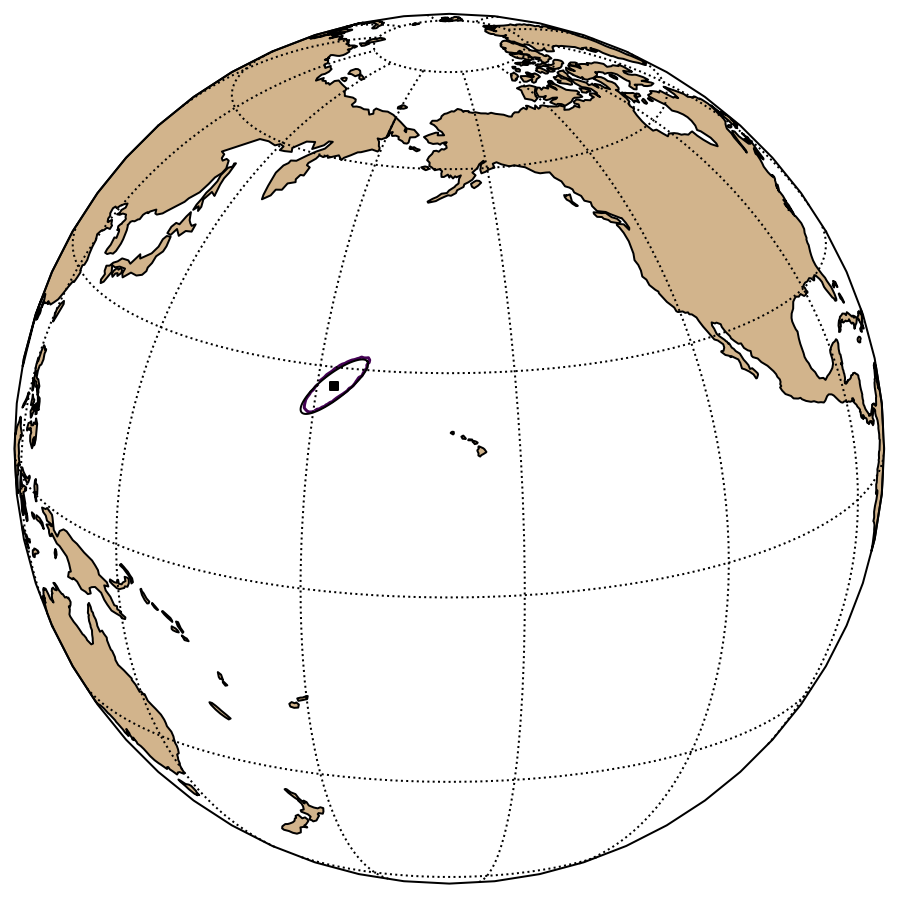

In [22]:
m = ipmag.make_orthographic_map(200, 20)
plot_distributions(m, mean_lons, mean_lats, to_plot='e', resolution = 500, cmap='viridis')
ipmag.plot_pole_ellipse(m,kent_distribution_95)

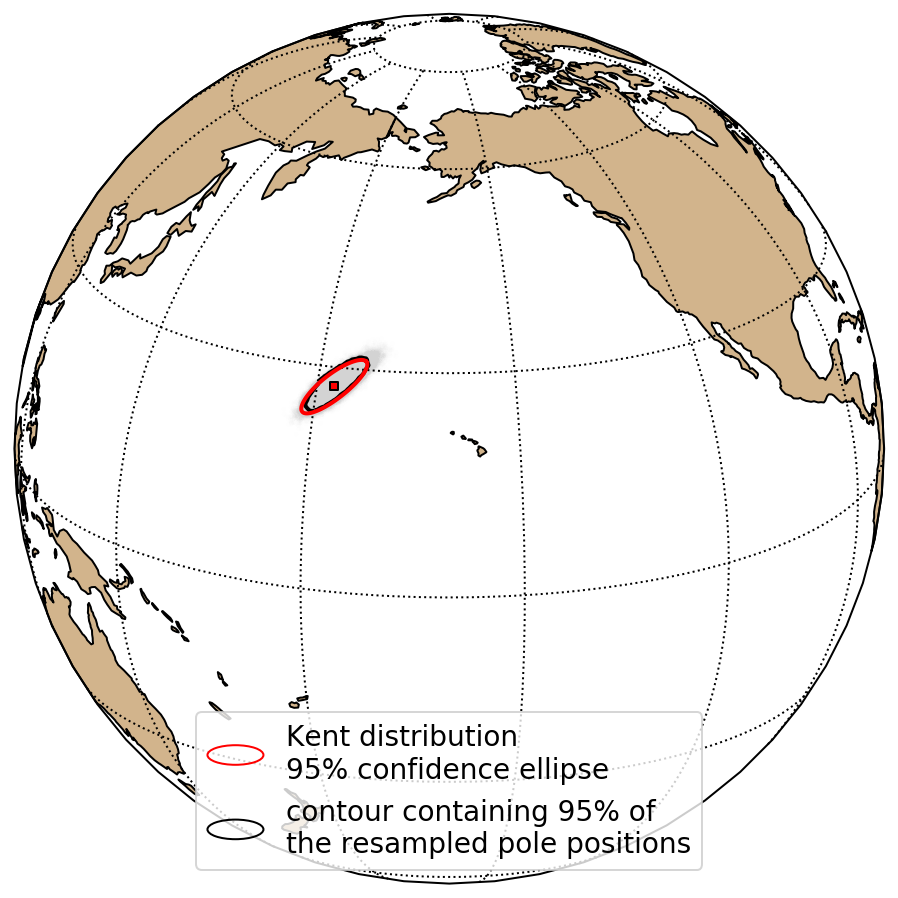

In [159]:
m = ipmag.make_orthographic_map(200, 20)
plot_vgp(m, mean_lons, mean_lats, color='lightgray', edge='none', markersize=5, alpha=0.01)

plot_distributions(m, mean_lons, mean_lats, to_plot='e', resolution = 500, colors='k', lw=2, zorder = 2)
ipmag.plot_pole_ellipse(m,kent_distribution_95, color='red', lw=2)
# m.legend()
colors = ["r", "k"]
texts = ["Kent distribution\n95% confidence ellipse", "contour containing 95% of\nthe resampled pole positions"]
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=width + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


c = [mpatches.Circle((0.5, 0.5), 1, edgecolor=colors[i], facecolor='none',linewidth=1) for i in range(len(texts))]
plt.legend(c,texts, loc='lower center', ncol=1, handler_map={mpatches.Circle: HandlerEllipse()}, fontsize=14)

plt.savefig('../code_output/Kent_ellipse.png', bbox_inches='tight', dpi=300)
plt.show()

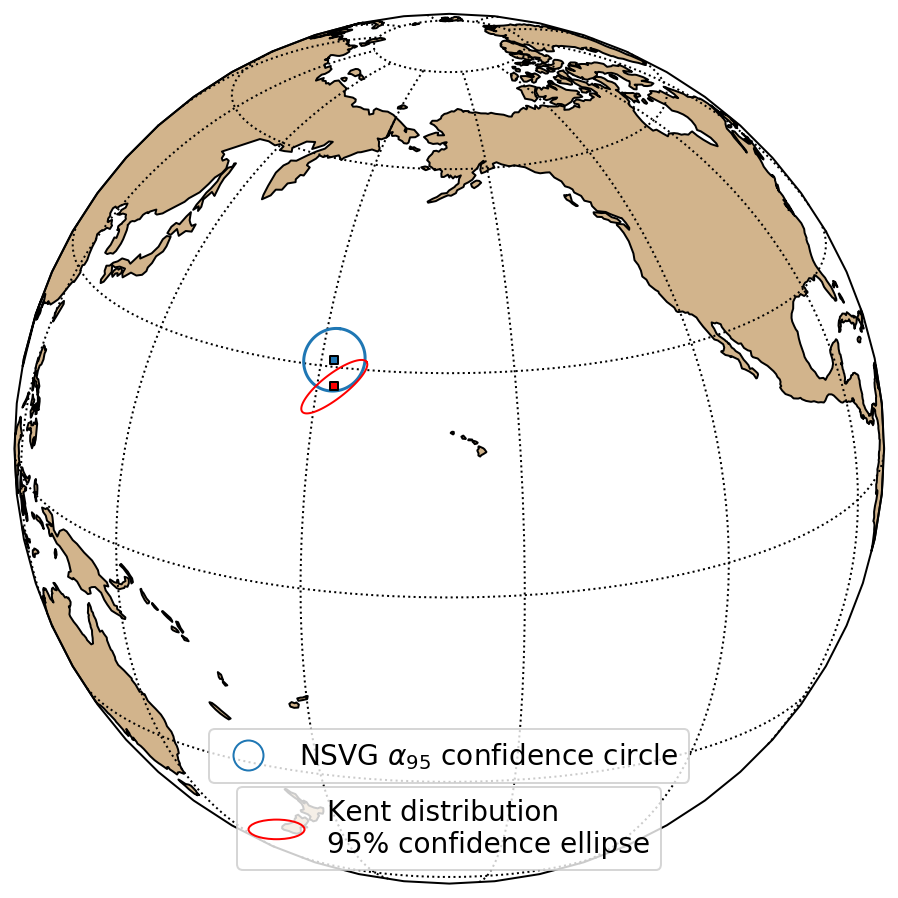

In [196]:
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_pole(m,182,31,4.2,label='North Shore Volcanic Group (upper NE)',marker='s',color='C0')
ipmag.plot_pole_ellipse(m,kent_distribution_95, color='r')

# legend_1 = plt.legend([Line2D([0], [0], marker='o', color='k', markerfacecolor="none")],[], loc='lower center', fontsize=14)

circle = Line2D([0], [0], marker='o', color='C0', label=r'NSVG $\alpha _{95}$ confidence circle',
                        markerfacecolor='none', markersize=15, ls='none'),
legend_1 = plt.legend(handles=circle, bbox_to_anchor=[0.5, 0.1], loc=8, fontsize=14)
plt.gca().add_artist(legend_1)
plt.legend([mpatches.Circle((0.5, 0.5), 1, edgecolor='r', facecolor='none',linewidth=1)],['Kent distribution\n95% confidence ellipse'], loc='lower center', 
           handler_map={mpatches.Circle: HandlerEllipse()}, fontsize=14)


plt.savefig('../code_output/Cutface_NSVF_pole_comparison.pdf', bbox_inches='tight')